In [1]:
from pcb_twin.multipath_grid_env import MultiPathGridEnv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
import random
import matplotlib.pyplot as plt
from agents.drqn_agent import DRQNAgent
from replay_buffers import DRQN_ReplayBuffer
from IPython.display import display, clear_output
from IPython.core.debugger import set_trace 
import csv 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
torch.__version__

'1.10.0'

# Environment Setup 

In [5]:
n_agents = 1
grid_size = [15,10]
obs_size = [40,40] # Basically get full grid :-) [for now!]
obstacles = [(3,3),(6,2), (6,3), (9,4), (9,3), (10,4), (8,9), (8,8)]
starts = [(13,8)]
goals = [(1,1)] # orig: (2,1) 
to_train = True 

In [6]:
env1 = MultiPathGridEnv(obstacles, starts, goals, grid_size=grid_size, obs_size=obs_size, agents_n=n_agents, train=to_train) 

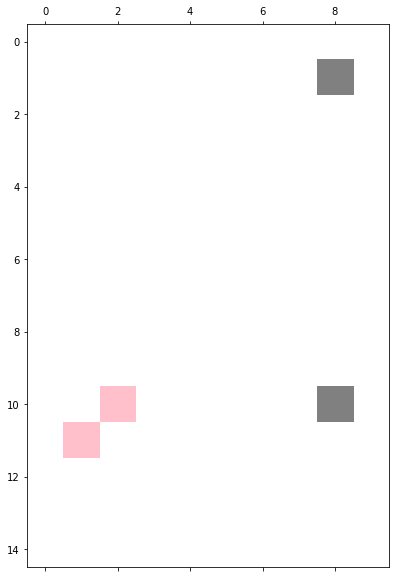

In [7]:
env1.render()

# DRQN

In [8]:
state_dim = grid_size[0]*grid_size[1]
action_dim = 8

### Training

In [9]:
drqn_agent = DRQNAgent(action_dim, DRQN_ReplayBuffer(100), device)
reward_sums_list = []
epsilon_history = []

In [10]:
def train_agent(agent):
    N = 100000
    max_time_steps = 3000
    epsilon = 0.4
    decay = 0.9999
    min_epsilon = 0.1

    for episode in range(N):
        reward_sum = 0
        episode_experience = []
        state = env1.reset()
        epsilon = max(min_epsilon, epsilon*decay)
        epsilon_history.append(epsilon)
        for i in range(max_time_steps):
            t_state = (torch.from_numpy(state[0]).float().to(device),torch.Tensor([state[1]]).to(device))
            action = agent.epsilon_greedy_action(t_state, epsilon)
            if type(action) is not list:
                action = [action]
            next_state, reward, terminal = env1.step(action)
            buff_state = (state[0].reshape(1,grid_size[0],grid_size[1]), state[1])
            obs = (buff_state, action, [reward])
            episode_experience.append(obs)
            reward_sum += reward
            state = next_state
            env1.render()
            if terminal:
                reward_sums_list.append(reward_sum)
                reward_sum = 0
                agent.memory.add_to_buffer(tuple(episode_experience))
                break
        if episode !=0:
            agent.update(5)

In [11]:
train_agent(drqn_agent)

AttributeError: 'MultiPathGridEnv' object has no attribute 'start_obs'